# 011. PyTorch Dataset

### Dataset 클래스

 - PyTorch는 두 개의 데이터 관련 클라스를 제공하여 pre-loaded datasets 및 custom dataset 을 사용할 수 있도록 한다.

     - torch.utils.data.Dataset - 샘플 및 해당 레이블을 제공
     - torch.utils.data.DataLoader - 샘플에 쉽게 액세스 할 수 있도록 Dataset의 iterable 을 wrapping
     

- PyTorch domain library (Image, Text, Audio dataset) 들은 torch.utils.data.Dataset 을 상속 받은 pre-loaded dataset (ex. FashionMNIST)과 관련 함수 제공


- torch.utils.data.Dataset 은 데이터셋을 나타내는 추상클래스이다.


- custom 데이터셋은 Dataset 을 상속하고 아래와 같이 Dataset method 를 오버라이드 하여 작성


    - 생성자 __init__ 은 dataset 의 전처리를 해주는 부분
    - len(dataset) 에서 호출되는 __len__ 은 데이터셋의 크기를 리턴
    - dataset[i] 에서 호출되는 __getitem__ 은 𝑖 번째 샘플을 찾는데 사용

In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import transforms

## 사용자 정의 Dataset 작성

- 특정 길이의 data를 생성하는 사용자 정의 Dataset class  
- transform object를 전달 받으면 data 변환을 하여 반환  
- iterable형태로 사용

In [2]:
class toy_set(Dataset):
    def __init__(self, length=10, transform=None):
        # reproducability
        torch.manual_seed(101)
        # dataset 을 전처리
        self.x = 10 * torch.ones(length, 2)
        self.y = torch.ones(length, 1)
        self.len = length
        self.transform = transform

    def __getitem__(self, idx):
        # idx 번째 sample 1 개를 가져오는 함수
        sample = self.x[idx], self.y[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample

    def __len__(self):
        # dataset의 길이를 반환
        return self.len

### iterable 형태로 사용
- len(dataset)  
- dataset[ i ]

In [3]:
test_data = toy_set()

len(test_data)

10

In [4]:
for i in range(3):
    x, y = test_data[i]
    print(x, y)

tensor([10., 10.]) tensor([1.])
tensor([10., 10.]) tensor([1.])
tensor([10., 10.]) tensor([1.])


In [5]:
for x, y in test_data:
    print(x, y)
    break

tensor([10., 10.]) tensor([1.])


In [6]:
next(iter(test_data))

(tensor([10., 10.]), tensor([1.]))

## Transform 적용

- 사용자 정의 transform module 을 Custom Dataset 에 적용

### Transform 함수 적용 예 : scaling

In [7]:
def scaling(sample):
    x, y = sample
    scaled_x = x / 10.
    scaled_y = y / 10.
    return scaled_x, scaled_y

In [8]:
dataset_ = toy_set(10, transform=scaling)

dataset_[-1]

(tensor([1., 1.]), tensor([0.1000]))

### transform class 적용 예

In [9]:
class add_ones:
    def __init__(self, added=1):
        self.added = added

    def __call__(self, sample):
        x, y = sample
        x = x + self.added
        y = y + self.added
        sample = x, y
        return sample

In [10]:
a_m = add_ones()

dataset_ = toy_set(10, transform=a_m)
dataset_[-1]

(tensor([11., 11.]), tensor([2.]))

### Transform 을 동시에 여러개 적용 : transform.Compose

In [11]:
from torchvision import transforms

data_transforms = transforms.Compose([scaling, a_m])

In [12]:
data1 = toy_set(5)
next(iter(data1))

(tensor([10., 10.]), tensor([1.]))

In [13]:
data2 = toy_set(5, transform=data_transforms)
next(iter(data2))

(tensor([2., 2.]), tensor([1.1000]))

<h1>pre-built Datasets and Transforms</h1>

In [14]:
import torchvision.transforms as transforms
from torchvision import datasets

In [15]:
crop_tensor_transform = transforms.Compose(
                    [transforms.CenterCrop(20),
                     transforms.ToTensor()])

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=crop_tensor_transform
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=crop_tensor_transform
)

In [16]:
training_data[0][0].shape

torch.Size([1, 20, 20])

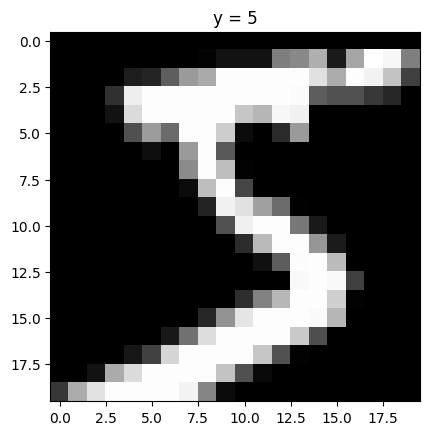

In [17]:
import matplotlib.pyplot as plt

plt.imshow(training_data[0][0].view(20, 20), cmap="gray")
plt.title("y = {}".format(training_data[0][1]))
plt.show()

## 데이터세트 반복 및 시각화

``training_data[index]`` 와 같이 ``Datasets``를 수동으로 인덱싱할 수 있습니다.


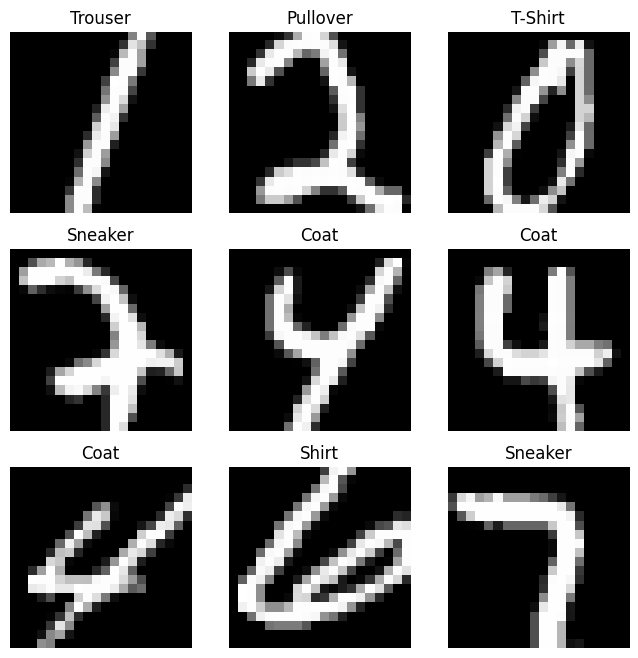

In [18]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## 파일에 대한 사용자 정의 데이터 세트 만들기

사용자 정의 Dataset 클래스는 `__init__`, `__len__` 및 `__getitem__`의 세 가지 함수를 구현해야 합니다.
이 예에서 FashionMNIST 이미지는 ``img_dir`` 디렉터리에 저장되고 해당 라벨은 CSV 파일 ``annotations_file``에 별도로 저장됩니다.

다음 섹션에서는 이러한 각 기능에서 어떤 일이 일어나는지 자세히 살펴보겠습니다.

In [19]:
import os
import pandas as pd
from torchvision.io import read_image
import skimage
print(skimage.data_dir)

/root/.cache/scikit-image/0.19.3/data


## 파일에 대한 사용자 정의 데이터 세트 만들기

사용자 정의 Dataset 클래스는 `__init__`, `__len__` 및 `__getitem__`의 세 가지 함수를 구현해야 합니다.

__len__ 함수는 데이터 세트의 샘플 수를 반환합니다.

__getitem__ 함수는 주어진 인덱스 ``idx``에 있는 데이터 세트에서 샘플을 로드하고 반환합니다.
인덱스를 기반으로 디스크에서 이미지의 위치를 식별하고 ``read_image``를 사용하여 이를 텐서로 변환하고 ``self.img_labels``의 csv 데이터에서 해당 레이블을 검색하고 이에 대한 변환 함수를 호출합니다. 텐서 이미지와 해당 레이블을 튜플로 반환합니다.



In [20]:
# 사용자 정의 이미지 데이터셋 클래스를 정의
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        # 이미지 레이블이 기록된 파일의 경로를 img_labels 속성에 저장합니다.
        self.img_labels = annotations_file
        # img_dir: 이미지 파일들이 저장된 디렉토리의 경로
        self.img_dir = img_dir
        # transform: 이미지 데이터에 적용할 전처리 함수입니다.
        self.transform = transform
        # target_transform: 레이블 데이터에 적용할 전처리 함수입니다.
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # 이미지 파일 경로를 생성합니다. self.img_dir는 이미지들이 위치한 폴더,
        # self.img_labels[idx][0]은 해당 인덱스의 이미지 파일 이름입니다.
        img_path = os.path.join(self.img_dir, self.img_labels[idx][0])

        # 생성한 이미지 파일 경로를 사용하여 이미지를 읽고 텐서로 변환합니다.
        image = read_image(img_path)
        # 해당 인덱스의 레이블을 가져옵니다. self.img_labels[idx][1]은 레이블 값입니다.
        label = self.img_labels[idx][1]

        # transform이 정의되어 있으면, 이미지에 transform을 적용합니다.
        if self.transform:
            image = self.transform(image)

        # target_transform이 정의되어 있으면, 레이블에 target_transform을 적용합니다.
        if self.target_transform:
            label = self.target_transform(label)

        # 변환된 이미지와 레이블을 튜플로 반환합니다.
        return image, label

labels.csv 파일은 다음과 같습니다.

    tshirt1.jpg, 0
    tshirt2.jpg, 0
    ......
    ankleboot999.jpg, 9

In [21]:
file_list = [
    ("page.png", 0),
    ("chelsea.png", 1),
    ("astronaut.png", 2),
    ("rocket.jpg", 3),
    ("motorcycle_right.png", 4)]

In [22]:
img_read = CustomImageDataset(file_list, skimage.data_dir)
len(img_read)

5

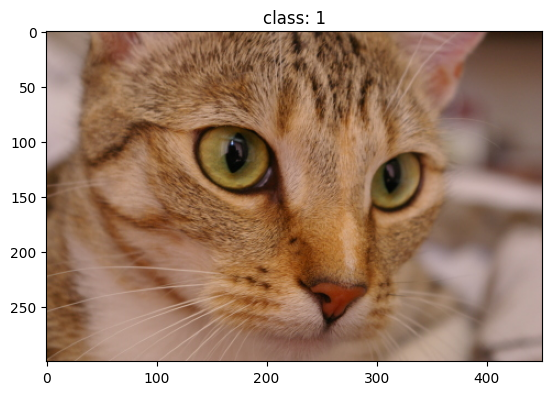

In [23]:
img, label = img_read[1]

img = img.permute(1, 2, 0)

plt.imshow(img)
plt.title("class: {}".format(label))
plt.show()

## DataLoader를 사용하여 training 데이터 준비

Dataset은 `한 번에 한 개씩 샘플`의 feature 와 label 을 retreive 합니다. 모델을 훈련하는 동안 일반적으로 `minibatch`로 샘플을 전달하고, 매 epoch 마다 데이터를 reshuffle 하여 overfitting을 줄이며, Python의 multiprocessing을 사용하여 읽는 속도를 높입니다.

DataLoader는 쉬운 API로 이러한 복잡성 내용을 추상화한 반복자(iterable) 입니다.

In [24]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

## DataLoader를 통해 반복
해당 데이터 세트를 ``Dataloader``에 로드 했으며 반복할 수 있습니다. 아래의 각 반복은`` train_features`` 및 ``train_labels`` ( batch_size=64 의 feature 및 label) 의 배치를 반환합니다.  ``shuffle=True``를 지정했기 때문에 모든 배치를 반복한 후에 데이터가 섞입니다.

In [25]:
train_features, train_labels = next(iter(train_dataloader))

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([64, 1, 20, 20])
Labels batch shape: torch.Size([64])


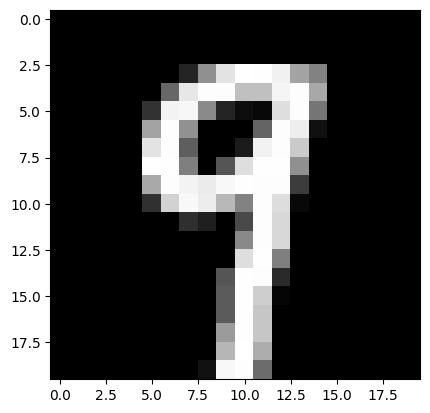

Label: 9


In [26]:
# Display image and label.
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

## TensorDataset
- PyTorch의 TensorDataset은 tensor를 감싸는 Dataset입니다.
- TensorDataset은 Dataset을 상속한 클래스로 학습 데이터 X와 레이블 Y를 묶어 놓는 컨테이너입니다.
- TensorDataset을 DataLoader에 전달하면 for 루프에서 데이터의 일부분만 간단히 추출할 수 있게 됩니다.  
- TensorDataset에는 텐서만 전달할 수 있으며, Variable은 전달할 수 없으니 주의
- Dataset은 직접 작성할 수도 있어서 대량의 이미지 파일을 한 번에 메모리에 저장하지 않고 필요할 때마다 읽어서 학습하는 등 다양하게 활용 가능

In [27]:
from torch.utils.data import TensorDataset

In [28]:
x = np.random.randn(5, 4)
y = np.random.randint(0, 2, size=5)

X_train = torch.from_numpy(x)
y_train = torch.from_numpy(y)

print(X_train)
print(y_train)

tensor([[ 0.4349, -0.4443,  0.7246, -0.2868],
        [ 0.9648, -0.2855, -1.6425, -1.0071],
        [-0.1078,  0.6574, -1.0854,  0.6866],
        [ 0.6389, -2.0321, -1.6706,  0.3220],
        [-0.1589,  0.4928,  0.5163, -0.5554]], dtype=torch.float64)
tensor([0, 0, 1, 0, 0])


In [29]:
train_ds = TensorDataset(X_train, y_train)
train_ds

In [30]:
train_dataloader = DataLoader(train_ds, batch_size=2, shuffle=False)
train_dataloader

In [31]:
train_features, train_labels = next(iter(train_dataloader))
train_features, train_labels

(tensor([[ 0.4349, -0.4443,  0.7246, -0.2868],
         [ 0.9648, -0.2855, -1.6425, -1.0071]], dtype=torch.float64),
 tensor([0, 0]))